# Part 1. Facebook Network

In this project, we will be using the dataset given below:

http://snap.stanford.edu/data/egonets-Facebook.html

The Facebook network can be created from the edgelist file (facebook combined.txt)

## 1. Structural properties of the Facebook network

### Question 1: A first look at the network.

NOTE:

- Diameter:  The length of the shortest path between the two farthest nodes in the graph
> What does Diameter stand for on the Facebook network? 
> - Small diameter ➔ indicates the "small world phenomenon" (six degrees of separation)
> -  Real social networks like Facebook are usually small in diameter (e.g., around 6).
> - Even if you don't know someone at all, it only takes six people to connect with them!

- Degree: How many neighbors a node has

- Degree distribution: The degree distribution of nodes across the network.
> - Most people have a modest number of friends (e.g., dozens)
> - But there are very few people who have many friends (become Hub nodes, such as super Internet celebrities)
> - This causes the degree distribution to be heavy-tailed


In [1]:
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import scipy
# download and read from local
G_fb = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph(), nodetype=int)

#### Question 1.1: 
Report the number of nodes and number of edges of the Facebook Network.

In [2]:
print('Answer:')
print('- Number of nodes of the FB network:', G_fb.number_of_nodes())
print('- Number of edges of the FB network', G_fb.number_of_edges())


Answer:
- Number of nodes of the FB network: 4039
- Number of edges of the FB network 88234


#### Question 1.2: 
Is the Facebook network connected? If not, find the giant connected component (GCC) of the network and report the size of the GCC.


In [3]:
print('Answer:')
if nx.is_connected(G_fb):
    print('Facebook network is connected.')
else:
    print('Facebook network is not connected:')
    '''# find GCC
    connected_components = list(nx.connected_components(G_fb))
    gcc = max(connected_components, key=len)
    # Create a subgraph of the GCC
    G_gcc = G_fb.subgraph(gcc).copy()
    print(f"The Giant Connected Component (GCC) contains {len(gcc)} nodes")
    print(f"This represents {len(gcc)/G_fb.number_of_nodes():.2%} of the total nodes")
    print(f"Number of edges in GCC: {G_gcc.number_of_edges()}")
    ''' 


Answer:
Facebook network is connected.


### QUESTION 2: 
Find the diameter of the network. If the network is not connected, then find the diameter of the GCC.

Since as previous code output, the network is connect, we won't need to find GCC.

Diameter of the network: 8


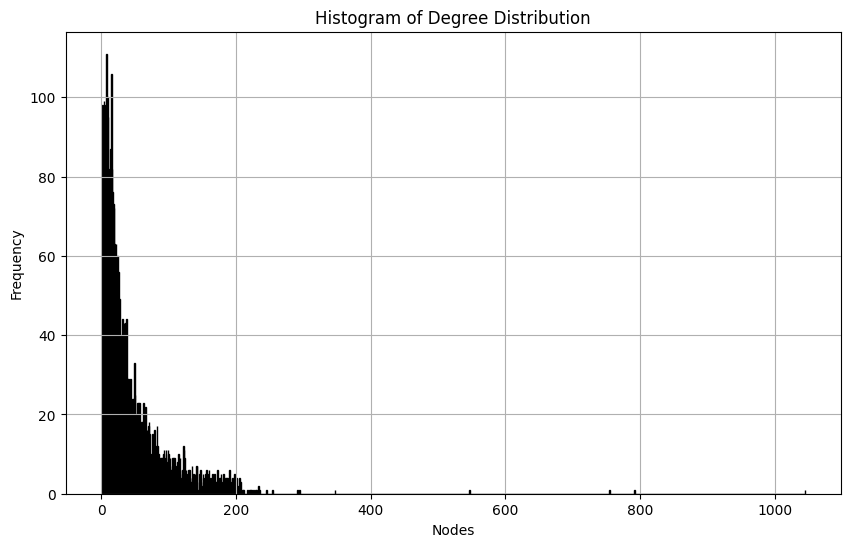

In [4]:
# Calculate the degree of each node
degree_sequence = [degree for node, degree in G_fb.degree()]
print('Diameter of the network:', nx.diameter(G_fb))

# Plot the histogram of degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degree_sequence, bins=range(0, max(degree_sequence) + 2), edgecolor='black', align='left')
plt.title("Histogram of Degree Distribution")
plt.xlabel("Nodes")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



### QUESTION 3: 
Plot the degree distribution of the facebook network and report the average degree.

Average degree: 43.69101262688784


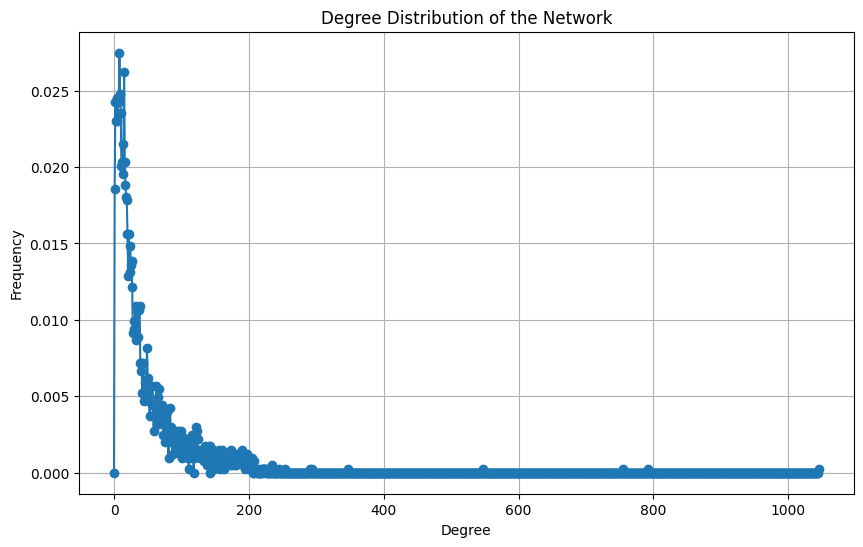

In [5]:
# Plot the degree distribution
# Calculate the average degree
average_degree = np.mean(degree_sequence)
print(f"Average degree: {average_degree}")
# Count the number of nodes for each degree and normalize to get frequency
degree_count = np.bincount(degree_sequence)
degree_prob = degree_count / sum(degree_count)

plt.figure(figsize=(10, 6))
plt.plot(range(len(degree_prob)), degree_prob, marker='o', linestyle='-')
plt.title("Degree Distribution of the Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### QUESTION 4: 
Plot the degree distribution of Question 3 in a log-log scale. 

Try to fit a line to the plot and estimate the slope of the line.

> Why a Log-Log Plot?
> - Ordinary degree plot can not see the tail clearly
> - A Log-Log Plot straights out the characteristics of a Power Law distribution
> - If it's a straight line, it's a typical Scale-free network
> - Facebook is likely to be close to scale-free (a structure common to real social networks)

Estimated slope (degree > 0): -1.1802


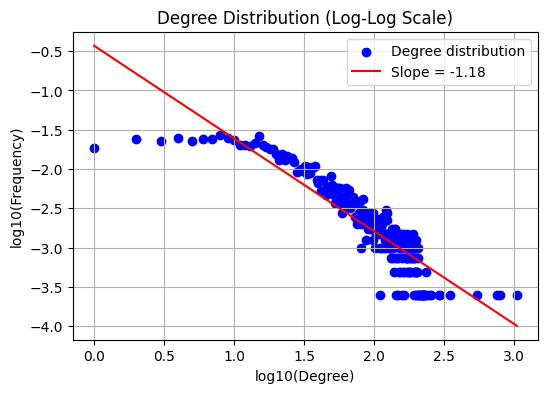

Estimated slope (degree > 5): -1.3769


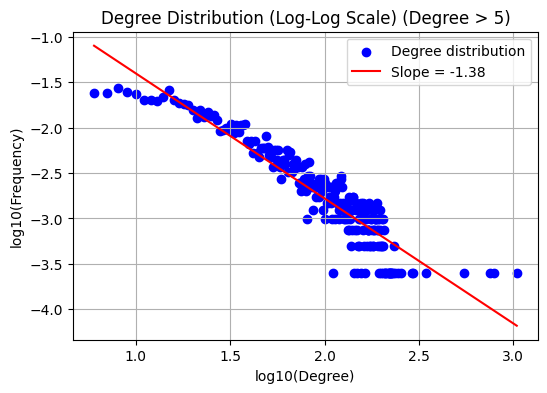

Estimated slope (degree > 10): -1.4557


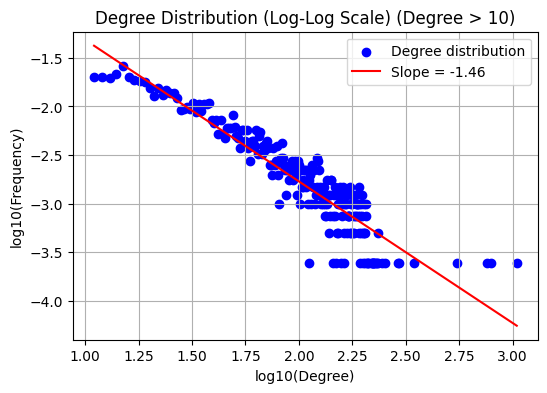

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def analyze_graph_loglog(G, threshold=None):
    degree_sequence = [d for _, d in G.degree()]
    degree_count = np.bincount(degree_sequence)
    degree_prob = degree_count / sum(degree_count)

    x = np.arange(len(degree_prob))
    y = degree_prob

    # Apply threshold filter
    mask = (x > threshold) & (y > 0) if threshold is not None else (x > 0) & (y > 0)
    log_x = np.log10(x[mask])
    log_y = np.log10(y[mask])

    if len(log_x) < 2:
        print("Not enough data points after filtering.")
        return

    # Fit a line in log-log space
    slope, intercept = np.polyfit(log_x, log_y, 1)

    # Print slope
    if threshold is not None:
        print(f"Estimated slope (degree > {threshold}): {slope:.4f}")
    else:
        print(f"Estimated slope: {slope:.4f}")

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(log_x, log_y, color="blue", label="Degree distribution")
    plt.plot(log_x, slope * log_x + intercept, color="red", label=f"Slope = {slope:.2f}")
    plt.title("Degree Distribution (Log-Log Scale)" + (f" (Degree > {threshold})" if threshold else ""))
    plt.xlabel("log10(Degree)")
    plt.ylabel("log10(Frequency)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
analyze_graph_loglog(G_fb, threshold=0)
analyze_graph_loglog(G_fb, threshold=5)
analyze_graph_loglog(G_fb, threshold=10)

Answer:

We analyzed the degree distribution of the Facebook network under different degree thresholds:

| Degree Threshold | Estimated Slope |
|:-----------------|:----------------|
| No threshold (degree > 0) | -1.1802 |
| Degree > 5 | -1.3769 |
| Degree > 10 | -1.4557 |

As the threshold increases, the slope becomes steeper, indicating that low-degree nodes flatten the distribution.  
Therefore, we consider **-1.46** (degree > 10) as a more reliable estimate of the network’s degree distribution. Although this slope is slightly smaller than the typical range (-2 to -3) observed in ideal scale-free networks, it reflects the characteristics of real-world social networks, where degree distributions often deviate from perfect power-law behavior.



## 2. Personalized network (graph node ID = 1 -> node id = 0 in edgelist)

> Personalized network: is a subgraph of node v_i and its neighbors (self + neighbors + edges between them).
> - Select the personalized network with node ID = 1.
> - Note: node ids in edgelist start at 0, so ID = 1 is the number 1 in edgelist.

/var/folders/pt/txr2ph2x1mg5gnx3y34z_1l00000gn/T/ipykernel_10835/1662668563.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(communities))


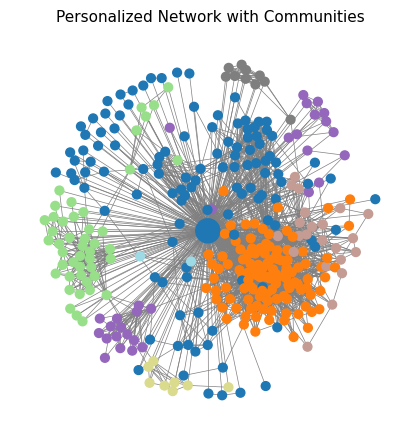

In [7]:
from networkx.algorithms import community

# 1. Create personalized network for node ID 1 (corresponds to node 0)
personalized_G = nx.ego_graph(G_fb, 0, radius=1)
# 2. Detect communities using greedy modularity
communities = community.greedy_modularity_communities(personalized_G)
# 3. Assign a color to each community
node_color = {}
colors = plt.cm.get_cmap('tab20', len(communities))
for idx, com in enumerate(communities):
    for node in com:
        node_color[node] = colors(idx)

node_colors = [node_color[node] for node in personalized_G.nodes()]
# 4. Layout
pos = nx.spring_layout(personalized_G, seed=42)
# 5. Set different node sizes: center node larger
node_sizes = []
for node in personalized_G.nodes():
    if node == 0:  # center node
        node_sizes.append(300)  # bigger
    else:
        node_sizes.append(40)   # smaller
# 6. Plot
plt.figure(figsize=(4, 4))
nx.draw(
    personalized_G, pos, node_color=node_colors, node_size=node_sizes, with_labels=False, edge_color='gray', width=0.5
)
plt.title("Personalized Network with Communities", fontsize=11)
plt.show()

### QUESTION 5: 
Create a personalized network of the user whose ID is 1. How many nodes and edges does this personalized network have?

Hint Useful function(s): `makeegograph` (from NetworkX, now it should call `ego_graph`)


In [8]:
print(f"Number of nodes in personalized network: {personalized_G.number_of_nodes()}")
print(f"Number of edges in personalized network: {personalized_G.number_of_edges()}")

Number of nodes in personalized network: 348
Number of edges in personalized network: 2866


### QUESTION 6: 

What is the diameter of the personalized network? Please state a trivial upper and lower bound for the diameter of the personalized network.


In [9]:
diameter = nx.diameter(personalized_G)
print(f"Diameter of the personalized network: {diameter}")

Diameter of the personalized network: 2


As code output, the diameter of the personalized network is **2**.

The diameter of a personalized network has a trivial upper bound of 2, because any node within the neighborhood subgraph can reach another by passing through the center node in at most two steps.

The trivial lower bound is 1, which occurs when the subgraph is fully connected, meaning every node is directly connected to every other node.


### QUESTION 7: 

In the context of the personalized network, 
- what is the meaning of the diameter of the personalized network to be equal to the upper bound you derived in *Question 6*. 
- What is the meaning of the diameter of the personalized network to be equal to the lower bound you derived in *Question 6*.
- (assuming there are more than 3 nodes in the personalized network)?

Ans:

- If the diameter reaches the upper bound (2), it means that not all nodes are directly connected to each other; some nodes can only reach others via the center node, implying the network is not fully connected.
- If the diameter is equal to the lower bound (1), it indicates that the personalized network forms a complete graph where all nodes are directly connected.


## 3. Core node’s personalized network

A core node is defined as the nodes that have more than 200 neighbors. For visualization purpose, we have displayed the personalized network of a core node below

In this part, we will study various properties of the personalized network of the core nodes.
### QUESTION 8: 
How many core nodes are there in the Facebook network. What is the average degree of the core nodes?

In [10]:
core_nodes = []  # stores (graph node ID, degree)

for node in G_fb.nodes():
    degree = G_fb.degree(node)
    if degree > 200: # def of code node
        # node + 1 is the graph ID according to the problem description
        core_nodes.append((node + 1, degree))

if core_nodes:
    avg_core_degree = sum([d for _, d in core_nodes]) / len(core_nodes)
    print(f"The network has {len(core_nodes)} core nodes with an average degree of {avg_core_degree:.3f}")
else:
    print("No core nodes found.")

The network has 40 core nodes with an average degree of 279.375


### 3.1. Community structure of core node’s personalized network

In this part, we study the community structure of the core node’s personalized network. To be specific, we will study the community structure of the personalized network of the following core nodes:
- Node ID 1
- Node ID 108
- Node ID 349
- Node ID 484
- Node ID 1087

#### QUESTION 9: 
For each of the above core node’s personalized network, find the community structure using Fast-Greedy, Edge-Betweenness, and Infomap community detection algorithms. Compare the modularity scores of the algorithms. For visualization purpose, display the community structure of the core node’s personalized networks using colors. Nodes belonging to the same community should have the same color and nodes belonging to different communities should have different color. In this question, you should have 15 plots in total.

Hint Useful function(s): `clusterfastgreedy` , `clusteredgebetweenness` , `clusterinfomap` (R)

Corresponding to `community_fastgreedy()`, `community_edge_betweenness()`, `community_infomap()` in python.





In [11]:
import random
random.seed(42)
def core_community_search(graph, node_id):
    node = graph.vs[node_id]
    node_nei_subgraph = graph.induced_subgraph(graph.neighborhood(node))
    
    fg_clusterings = node_nei_subgraph.community_fastgreedy().as_clustering()
    eb_clusterings = node_nei_subgraph.community_edge_betweenness(directed=False).as_clustering()
    info_clusterings = node_nei_subgraph.community_infomap()

    layout = node_nei_subgraph.layout("fr")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ig.plot(fg_clusterings, target=ax[0], layout=layout, vertex_size=10, mark_groups=True)
    ig.plot(eb_clusterings, target=ax[1], layout=layout, vertex_size=10, mark_groups=True)
    ig.plot(info_clusterings, target=ax[2], layout=layout, vertex_size=10, mark_groups=True)

    ax[0].set_title(f"Fast-Greedy\nModularity: {node_nei_subgraph.modularity(fg_clusterings):.3f}",
                    fontsize=12, fontweight='bold')
    ax[1].set_title(f"Edge-Betweenness\nModularity: {node_nei_subgraph.modularity(eb_clusterings):.3f}",
                    fontsize=12, fontweight='bold')
    ax[2].set_title(f"Infomap\nModularity: {node_nei_subgraph.modularity(info_clusterings):.3f}",
                    fontsize=12, fontweight='bold')

    plt.suptitle(f"Community Structure for Core Node (Graph ID {node_id + 1})", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

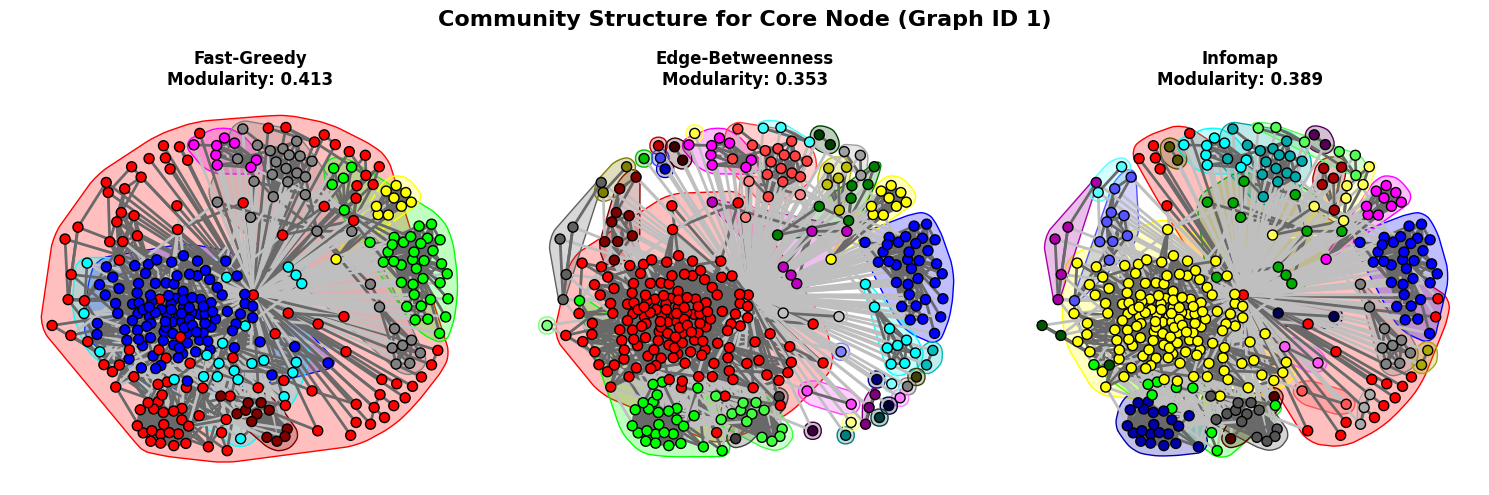

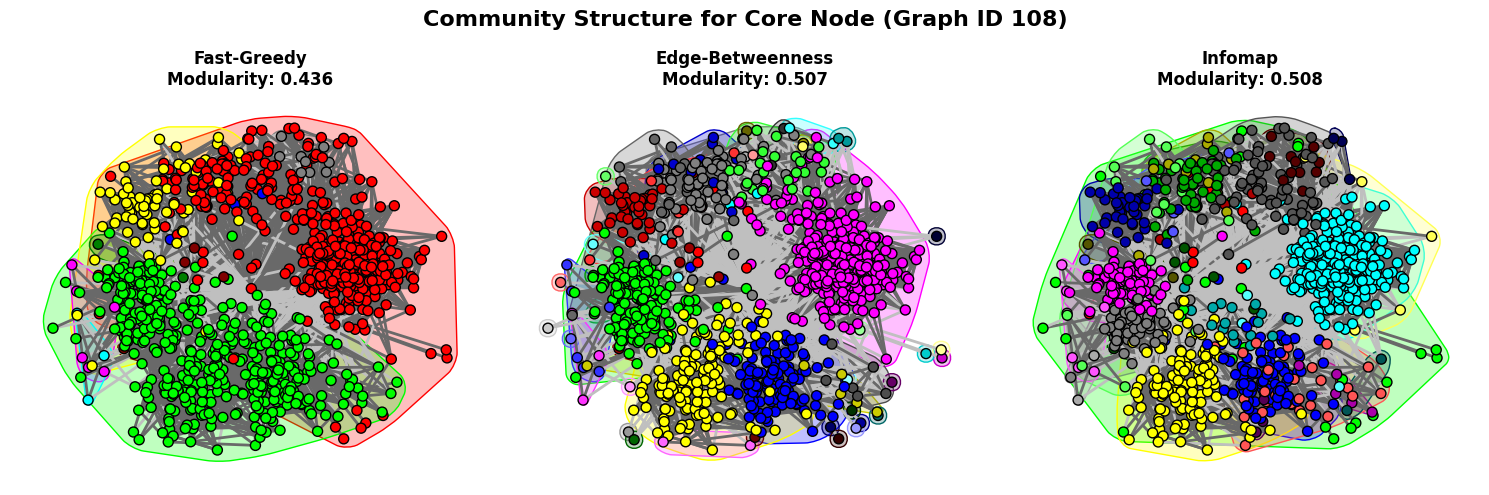

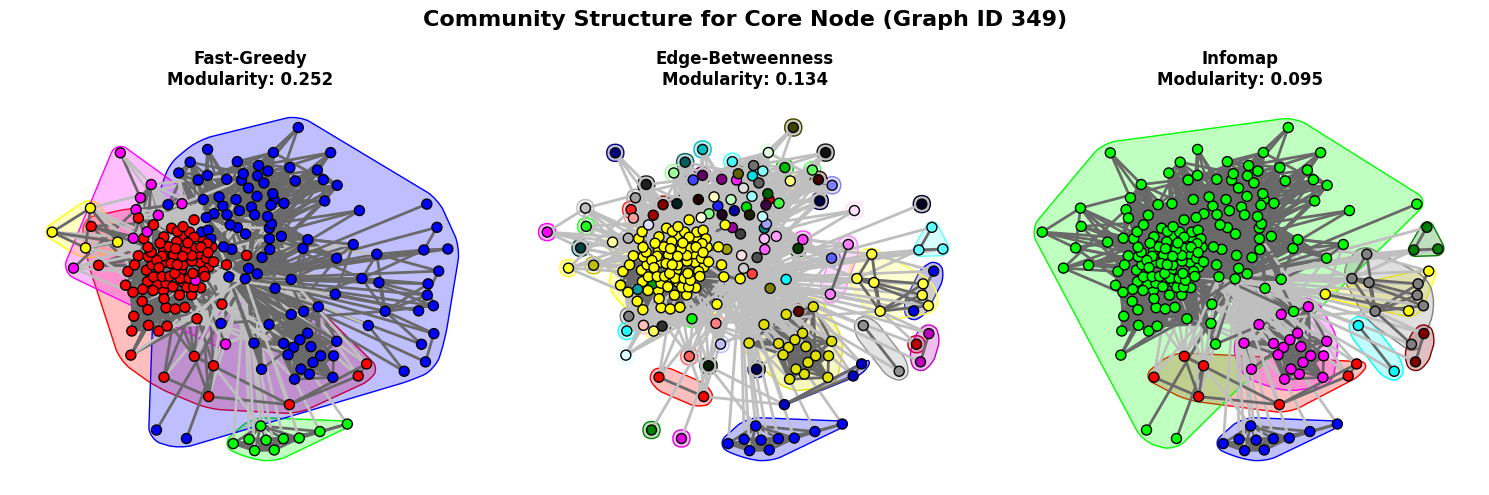

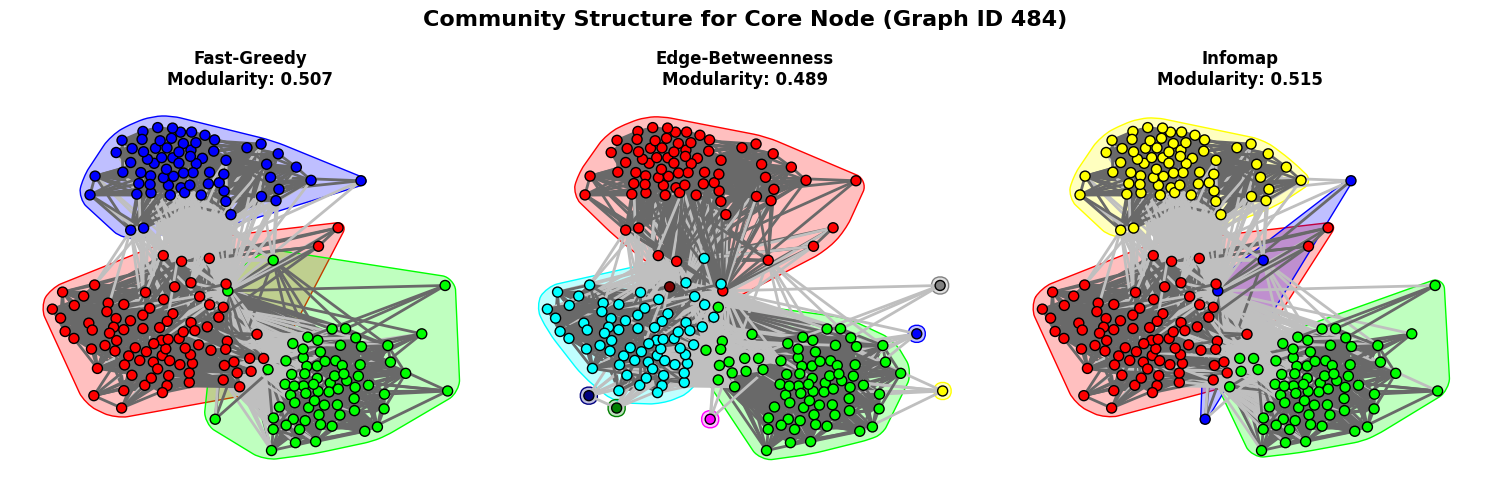

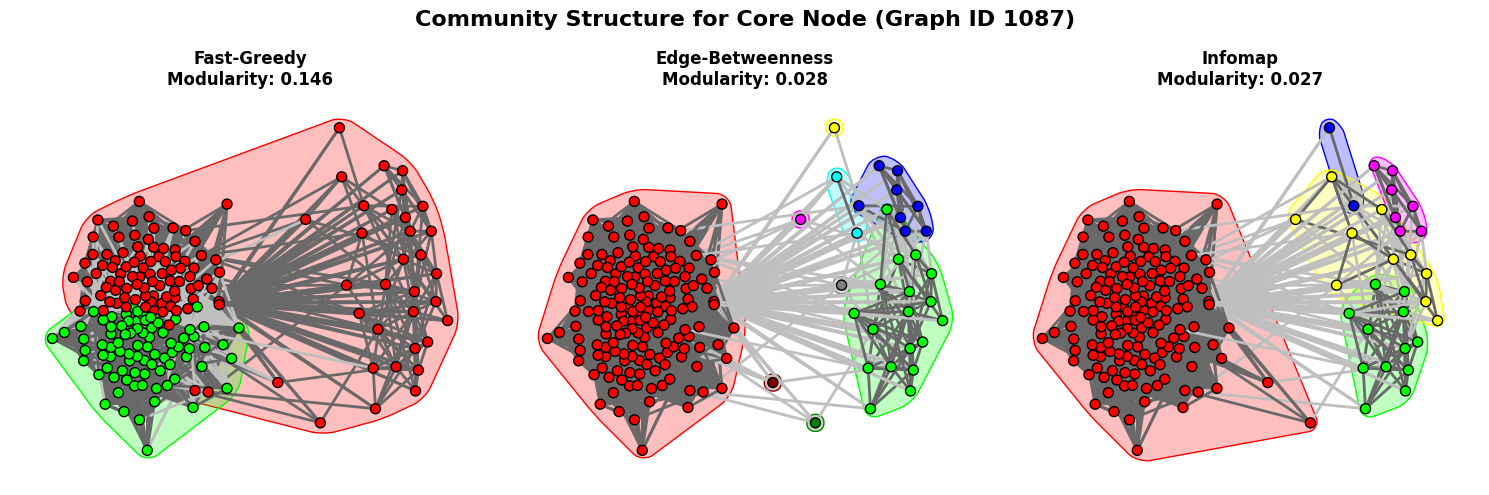

In [12]:
# List of core graph IDs
G_fb = ig.Graph.Read_Edgelist('facebook_combined.txt', directed=False)
# Set the "name" attribute of each node to its original index
G_fb.vs["name"] = [v.index for v in G_fb.vs]
core_graph_ids = [1, 108, 349, 484, 1087]
# edgelist node IDs (Graph ID - 1)
core_edgelist_ids = [id - 1 for id in core_graph_ids]
for node_id in core_edgelist_ids:
    core_community_search(G_fb, node_id)

We studied the community structure of the personalized networks of five core nodes (Graph IDs 1, 108, 349, 484, 1087) using Fast-Greedy, Edge-Betweenness, and Infomap community detection algorithms. The modularity scores are summarized below:

| Core Node (Graph ID) | Fast-Greedy Modularity | Edge-Betweenness Modularity | Infomap Modularity |
|:---|:---|:---|:---|
| 1 | 0.413 | 0.353 | 0.389 |
| 108 | 0.436 | 0.507 | 0.508 |
| 349 | 0.252 | 0.134 | 0.096 |
| 484 | 0.507 | 0.489 | 0.515 |
| 1087 | 0.146 | 0.028 | 0.027 |

Among the five core nodes, core node 484 has the highest modularity (0.515 using Infomap), indicating a strong community structure.  
For core node 108, both Edge-Betweenness and Infomap achieved higher modularity scores (~0.507–0.508) than Fast-Greedy.  
In general, Fast-Greedy and Infomap algorithms tend to produce higher modularity scores compared to Edge-Betweenness.  
Core node 1087 exhibits very weak community structure across all algorithms, as indicated by its low modularity scores.

### 3.2 Community structure with the core node removed
#### QUESTION 10: 
For each of the core node’s personalized network (use same core nodes as Question 9), remove the core node from the personalized network and find the community structure of the modified personalized network. Use the same community detection algorithm as Question 9. Compare the modularity score of the community structure of the modified personalized network with the modularity score of the community structure of the personalized network of Question 9. For visualization purpose, display the community structure of the modified personalized network using colors. In this question, you should have 15 plots in total.

In [13]:
import random
random.seed(42)
def core_community_search_without_core(graph, node_id):
    node = graph.vs[node_id]
    # remove the core node 
    new_neighbourhood = graph.neighborhood(node)
    new_neighbourhood.remove(node_id)
    # induce the subgraph without the core node
    node_nei_subgraph = graph.induced_subgraph(new_neighbourhood)

    fg_clusterings = node_nei_subgraph.community_fastgreedy().as_clustering()
    eb_clusterings = node_nei_subgraph.community_edge_betweenness(directed=False).as_clustering()
    info_clusterings = node_nei_subgraph.community_infomap()

    layout = node_nei_subgraph.layout("fr")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ig.plot(fg_clusterings, target=ax[0], layout=layout, vertex_size=10, mark_groups=True)
    ig.plot(eb_clusterings, target=ax[1], layout=layout, vertex_size=10, mark_groups=True)
    ig.plot(info_clusterings, target=ax[2], layout=layout, vertex_size=10, mark_groups=True)

    ax[0].set_title(f"Fast-Greedy\nModularity: {node_nei_subgraph.modularity(fg_clusterings):.3f}",
                    fontsize=12, fontweight='bold')
    ax[1].set_title(f"Edge-Betweenness\nModularity: {node_nei_subgraph.modularity(eb_clusterings):.3f}",
                    fontsize=12, fontweight='bold')
    ax[2].set_title(f"Infomap\nModularity: {node_nei_subgraph.modularity(info_clusterings):.3f}",
                    fontsize=12, fontweight='bold')

    plt.suptitle(f"Community Structure for Neighbourhood of Core Node {node_id + 1} (Core Removed)",
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

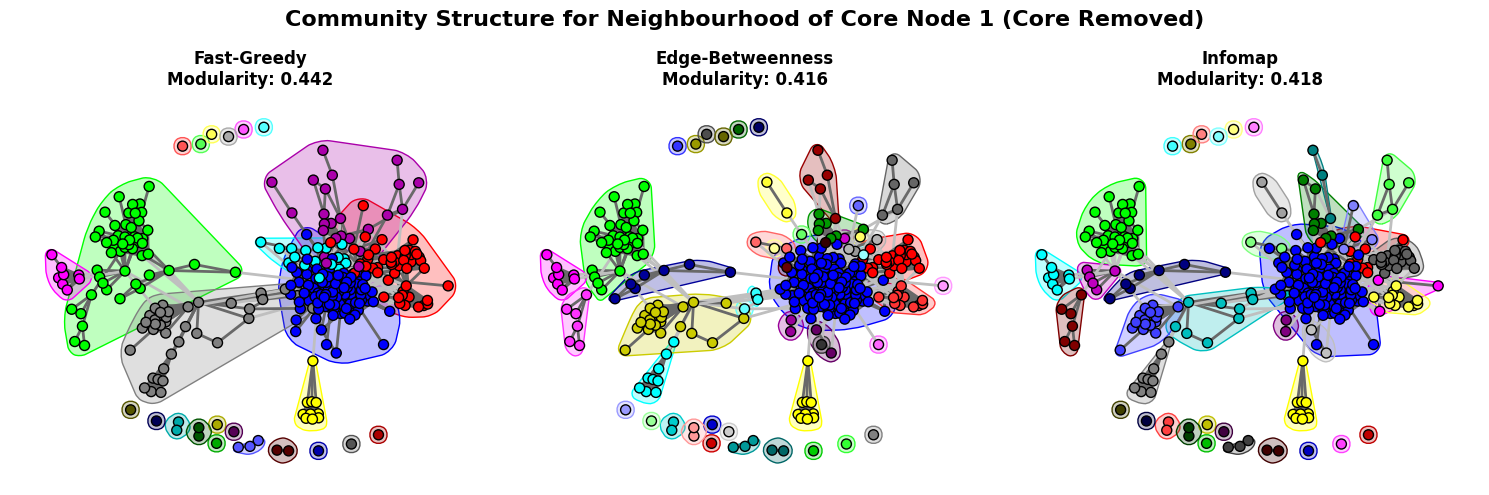

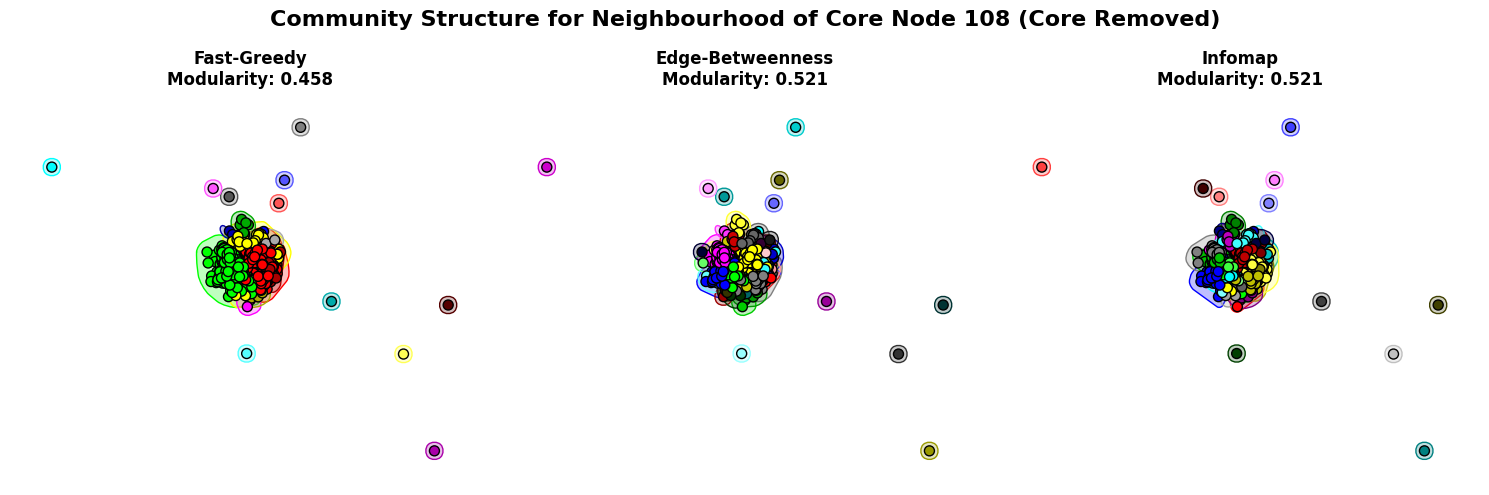

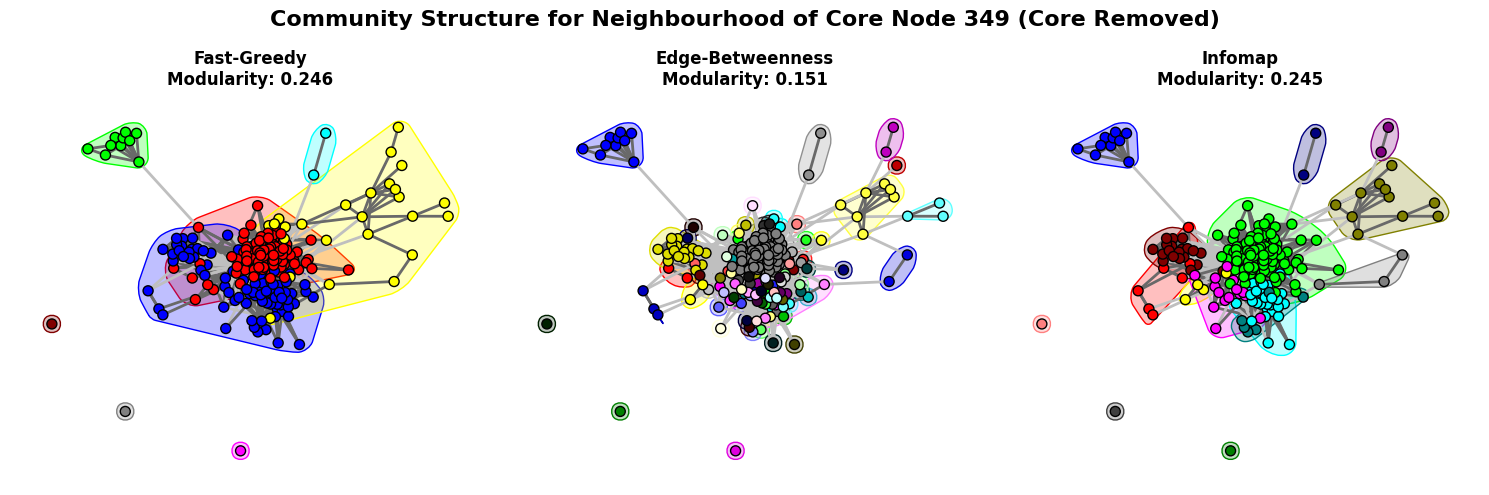

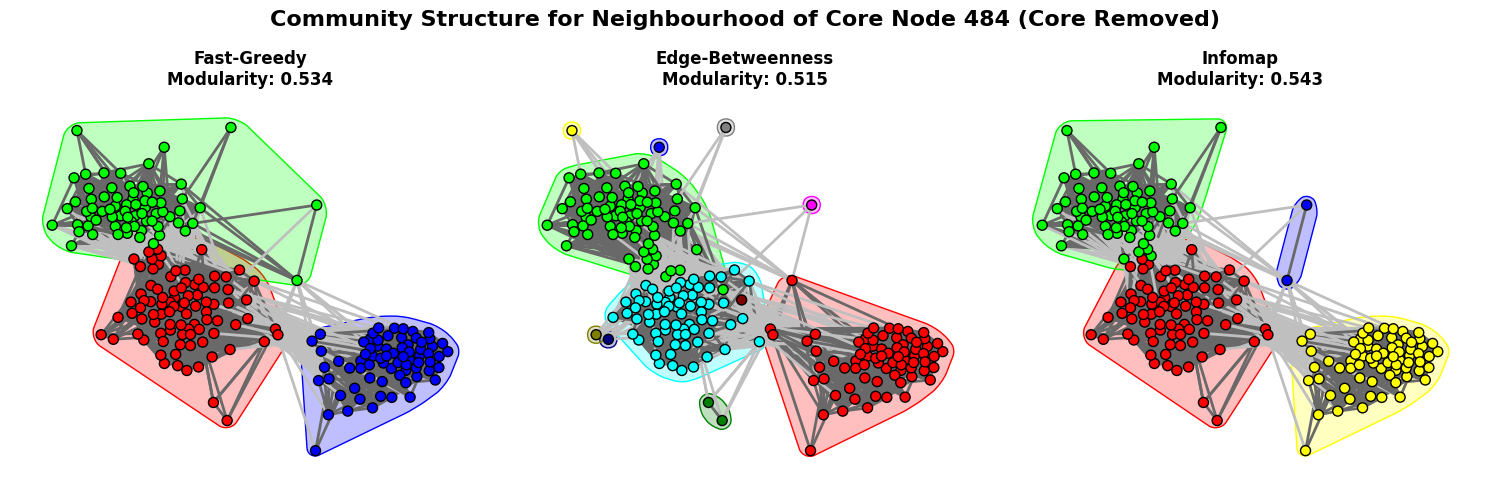

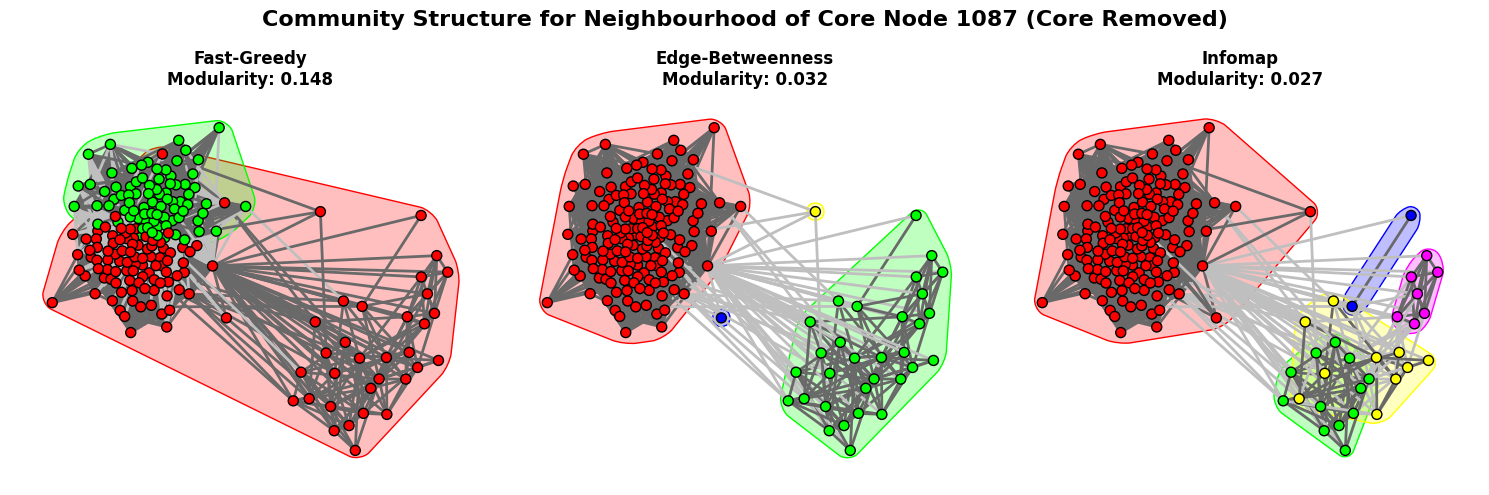

In [14]:
# List of core graph IDs
core_graph_ids = [1, 108, 349, 484, 1087]
# edgelist node IDs (Graph ID - 1)
core_edgelist_ids = [id - 1 for id in core_graph_ids]
for node_id in core_edgelist_ids:
    core_community_search_without_core(G_fb, node_id)

We studied the community structure of five core nodes' personalized networks (Graph IDs 1, 108, 349, 484, and 1087) using Fast-Greedy, Edge-Betweenness, and Infomap algorithms. We compared the modularity scores before and after removing the core node from the personalized network.


| Core Node (Graph ID) | Fast-Greedy (Before) | Fast-Greedy (After Core Node Removed) | Edge-Betweenness (Before) | Edge-Betweenness (After Core Node Removed) | Infomap (Before) | Infomap (After Core Node Removed) |
|:---|:---|:---|:---|:---|:---|:---|
| 1 | 0.413 | *0.442* | 0.353 | *0.416* | 0.389 | *0.418* |
| 108 | 0.436 | *0.458* | 0.507 | *0.521* | 0.508 | *0.519* |
| 349 | 0.252 | *0.246* | 0.134 | *0.151* | 0.096 | *0.247* |
| 484 | 0.507 | *0.534* | 0.489 | *0.515* | 0.515 | *0.543* |
| 1087 | 0.146 | *0.148* | 0.028 | *0.032* | 0.027 | *0.027* |

Observation:

- **Core Node 1**: After removing the core node, the modularity scores increased across all three algorithms, indicating a clearer community structure.
- **Core Node 349**: The Infomap modularity significantly increased after removal, while Fast-Greedy and Edge-Betweenness showed minor changes.
- **Core Node 484**: Modularity scores increased across all algorithms after core node removal, demonstrating an even stronger community structure.
- **Core Node 1087**: Modularity scores remained consistently low before and after removal, suggesting a weak inherent community structure.
- **Core Node 108**: Modularity scores also increased slightly after removal, indicating a slight improvement in community clarity.

Conclusion:

Removing the core node often leads to **higher modularity scores** and thus a **clearer community structure**, especially for nodes like 1, 108, and 484. However, in cases where the community structure is inherently weak (such as for core node 1087), removing the core node has minimal effect.

### 3.3. Characteristic of nodes in the personalized network

- Embeddedness of a node is defined as the number of mutual friends a node shares with the core node.
- Dispersion of a node is defined as the sum of distances between every pair of the mutual friends the node shares with the core node. The distances should be calculated in  modified graph where the node (whose dispersion is being computed) and the core node are removed.

Paper: http://arxiv.org/abs/1310.6753

####  QUESTION 11: 
Write an expression relating the Embeddedness between the core node and a non-core node to the degree of the non-core node in the personalized network of the core node

Suppose the core node is $n_0$ and a non-core node is $n_i$, then we have:

$$
\text{Embeddedness}(n_0, n_i) = \deg(n_i) - 1
$$

Reason:
Every non-core node $n_i$ is directly connected to the core node $n_0$ in the personalized network.
Thus, any node $n_j$ is a mutual friend between $n_0$ and $n_i$ if and only if $n_j$ is a neighbor of $n_i$ other than $n_0$.
Therefore, the number of mutual friends (embeddedness) equals the degree of $n_i$ minus one.

This relationship holds under the assumption that the personalized network includes only the core node and its immediate neighbors, and that every non-core node is directly connected to the core node.

#### QUESTION 12: 
For each of the core node’s personalized network (use the same core nodes as Question 9), plot the distribution histogram of embeddedness and dispersion. In this question, you will have 10 plots.

Hint Useful function(s): `neighbors` , `intersection` , `distances`



In [15]:
G_fb = ig.Graph.Read_Edgelist('facebook_combined.txt', directed=False)
# Set the "name" attribute of each node to its original index
G_fb.vs["name"] = [v.index for v in G_fb.vs]

In [16]:
def get_personalized_network(graph, core_node_id):
    core_node = graph.vs[core_node_id]
    nei_nodes = graph.neighborhood(core_node)
    return graph.induced_subgraph(nei_nodes), core_node

In [17]:
def calculate_embeddedness(personalized_network, core_node):
    embeddedness_list = []
    core_name = core_node["name"]

    for node in personalized_network.vs:
        if node["name"] == core_name:
            continue
        degree = personalized_network.degree(node)
        embeddedness_list.append(degree - 1)

    return embeddedness_list

In [18]:
def calculate_dispersion(personalized_network, core_node, return_type='list'):
    core_name = core_node["name"]
    core_index = personalized_network.vs.find(name=core_name).index

    dispersion_list = []
    dispersion_dict = {} # for question 13 & 14

    for node in personalized_network.vs:
        if node["name"] == core_name:
            continue

        mutual_friends = personalized_network.neighborhood(node)
        mutual_friends.remove(node.index)
        mutual_friends.remove(core_index)

        if len(mutual_friends) < 2:
            dispersion = 0
        else:
            subgraph = personalized_network.induced_subgraph(mutual_friends)
            distances = subgraph.distances()
            total_distance = sum(
                dist for row in distances for dist in row if dist != float("inf")
            ) / 2 
            dispersion = total_distance

        dispersion_list.append(dispersion)
        dispersion_dict[node.index] = dispersion

    if return_type == 'list':
        return dispersion_list
    elif return_type == 'dict':
        return dispersion_dict
    else:
        raise ValueError("return_type must be 'list' or 'dict'")

In [19]:
def plot_embeddedness_dispersion(graph, core_node_id):
    personalized_network, core_node = get_personalized_network(graph, core_node_id)
    
    embeddedness = calculate_embeddedness(personalized_network, core_node)
    dispersion = calculate_dispersion(personalized_network, core_node)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plot_configs = [
        (embeddedness, "Embeddedness", axes[0]),
        (dispersion, "Dispersion", axes[1])
    ]
    for data, title, ax in plot_configs:
        ax.hist(data, bins=30, edgecolor='black')
        ax.set_title(f'{title} Distribution\n(Core Node {core_node_id + 1})', fontsize=14, fontweight='bold')
        ax.set_xlabel(title, fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

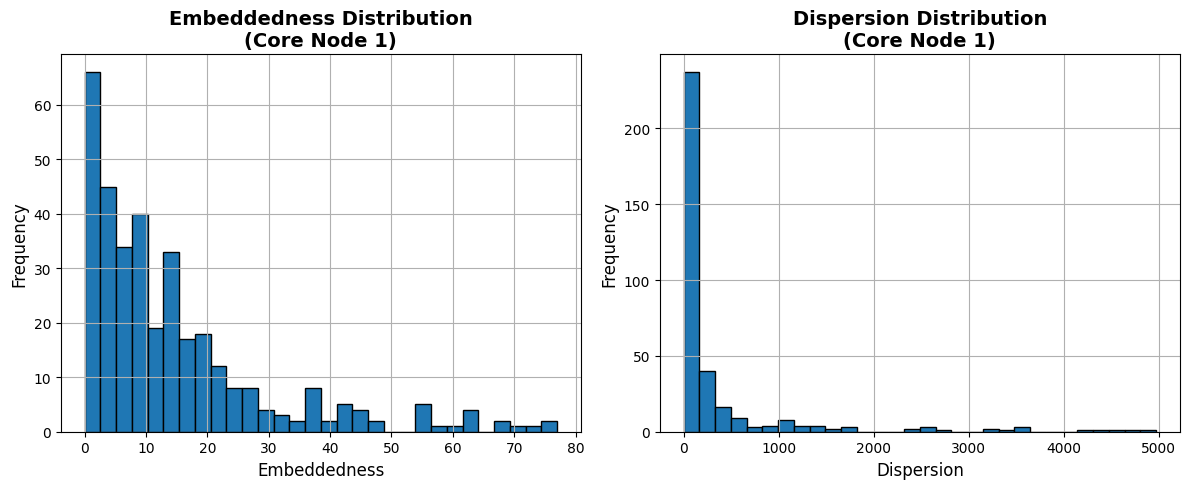

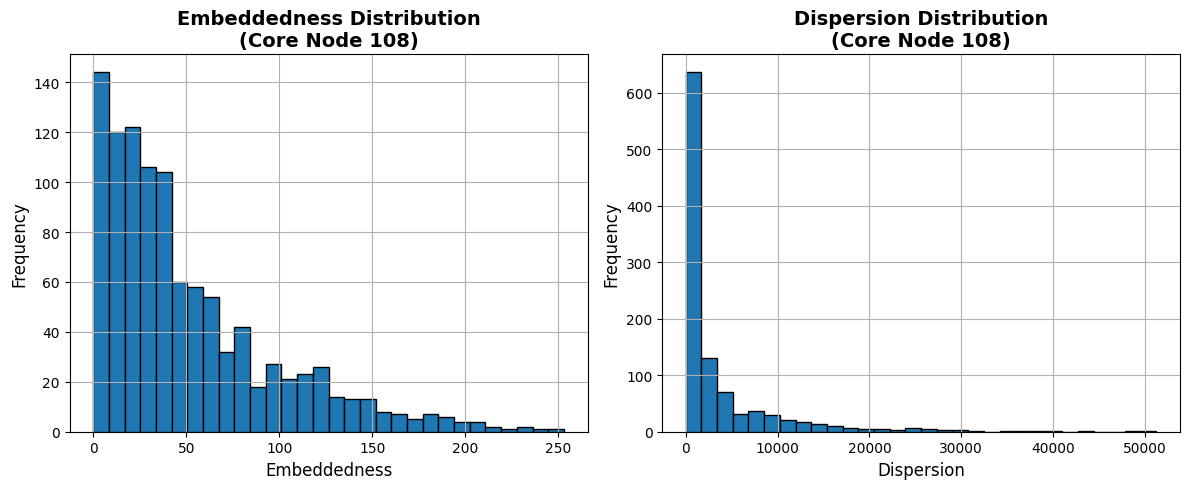

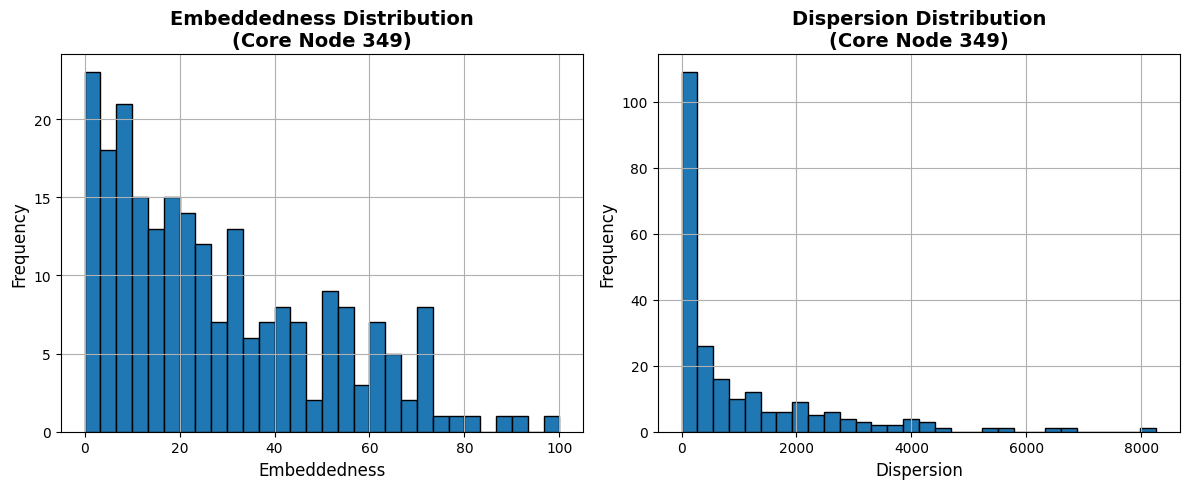

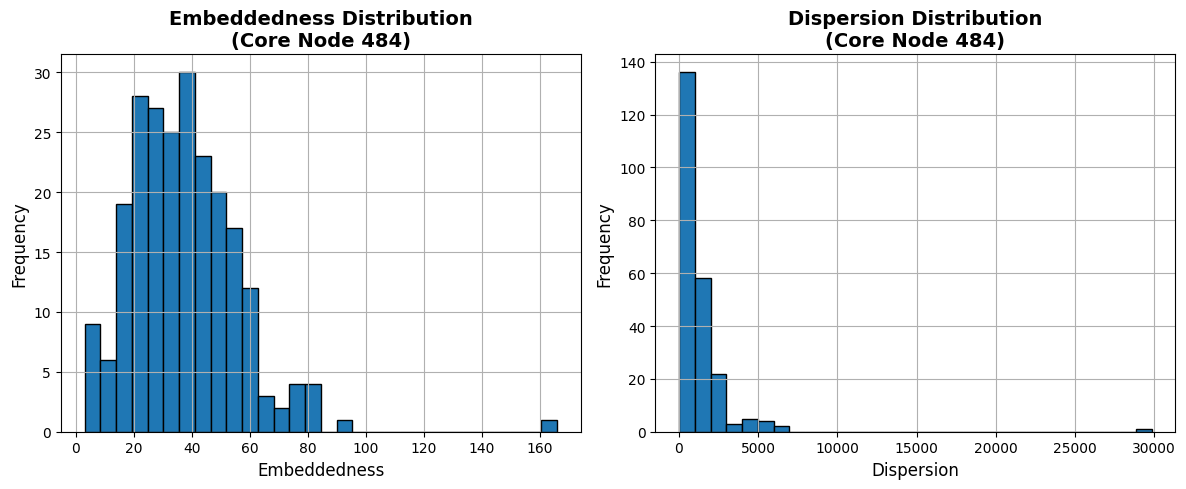

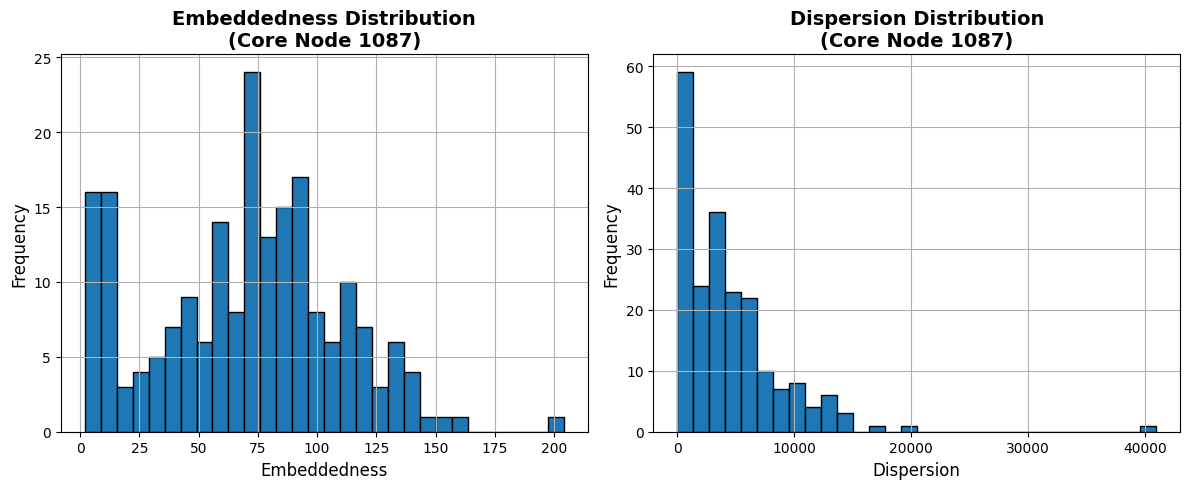

In [20]:
core_graph_ids = [1, 108, 349, 484, 1087]
core_edgelist_ids = [id - 1 for id in core_graph_ids] 
for core_id in core_edgelist_ids:
    plot_embeddedness_dispersion(G_fb, core_id)


#### QUESTION 13: 
For each of the core node’s personalized network, 
- plot the community structure of the personalized network using colors and highlight the node with maximum dispersion. 
- Also, highlight the edges incident to this node. To detect the community structure, use Fast-Greedy algorithm. In this question, you will have 5 plots.

In [21]:
def plot_community_with_max_dispersion(graph, core_node_id):

    personalized_network, core_node = get_personalized_network(graph, core_node_id)
    dispersion_values = calculate_dispersion(personalized_network, core_node, return_type='dict')
    community = personalized_network.community_fastgreedy().as_clustering()

    node_color = [community.membership[v] for v in range(len(personalized_network.vs))]
    node_size = [6] * len(personalized_network.vs)
    edge_color = ["gray"] * len(personalized_network.es)
    edge_width = [0.5] * len(personalized_network.es)

    # hghlight node with maximum dispersion
    max_dispersion_node = max(dispersion_values, key=dispersion_values.get)
    node_size[max_dispersion_node] = 30
    node_color[max_dispersion_node] = "black"

    incident_edges = personalized_network.incident(max_dispersion_node)
    for eid in incident_edges:
        edge_color[eid] = "black"
        edge_width[eid] = 3

    layout = personalized_network.layout("fr")
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    ig.plot(
        community, target=ax, layout=layout,
        vertex_color=node_color, vertex_size=node_size,
        edge_color=edge_color, edge_width=edge_width
    )
    max_node_original_id = personalized_network.vs[max_dispersion_node]["name"]
    plt.suptitle(
        f"Core Node ID = {core_node_id + 1}, Node with Max Dispersion ID = {max_node_original_id + 1}",
        fontsize=14, fontweight='bold'
    )
    plt.tight_layout()
    plt.show()

    print(f"Core node ID: {core_node_id + 1}")
    print(f"Node with maximum dispersion: {max_node_original_id + 1}")

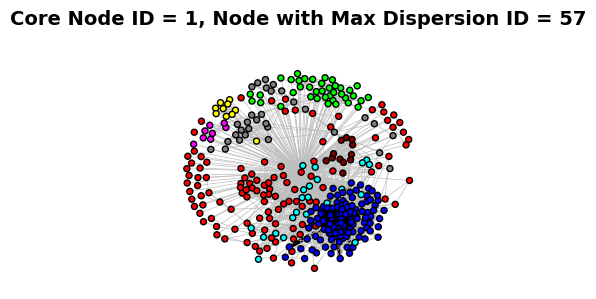

Core node ID: 1
Node with maximum dispersion: 57


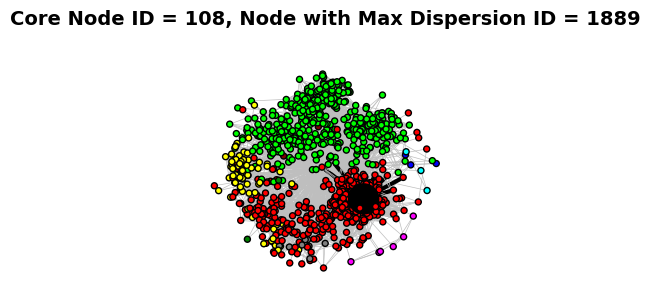

Core node ID: 108
Node with maximum dispersion: 1889


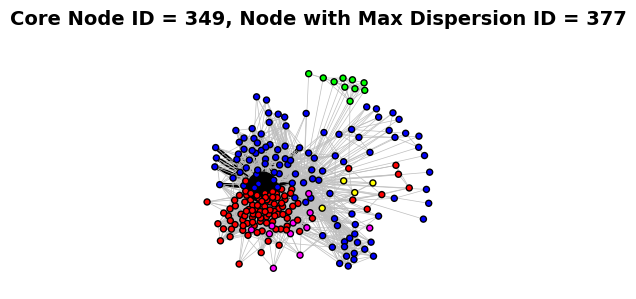

Core node ID: 349
Node with maximum dispersion: 377


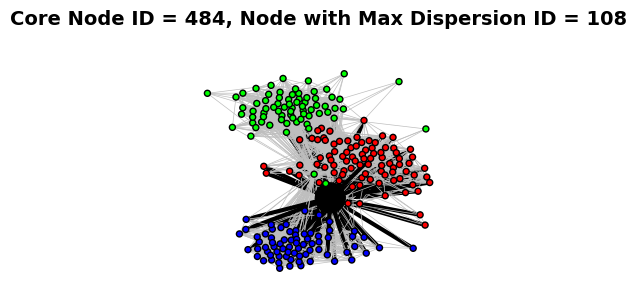

Core node ID: 484
Node with maximum dispersion: 108


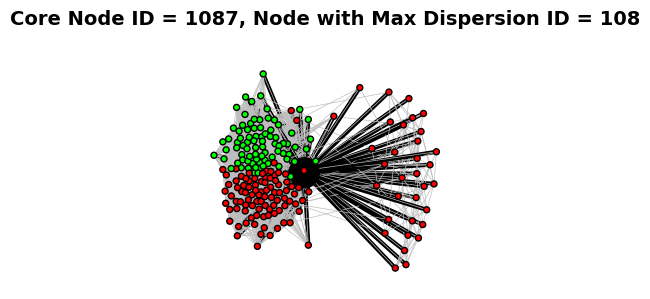

Core node ID: 1087
Node with maximum dispersion: 108


In [22]:
core_nodes_graph_id = [1, 108, 349, 484, 1087]
core_nodes_edge_id = [id - 1 for id in core_nodes_graph_id]
for core_id in core_nodes_edge_id:
    plot_community_with_max_dispersion(G_fb, core_id)

#### QUESTION 14:

Repeat Question 13, but now highlight:
- the node with maximum embeddedness, and
- the node with maximum $\dfrac{\text{dispersion}}{\text{embeddedness}}$ (excluding the nodes having zero embeddedness if there are any).

Also:
- Highlight the edges incident to these nodes.
- Report the ID of those nodes.

In [23]:

def plot_community_highlight_emb_disp_ratio(graph, core_node_id):
    personalized_network, core_node = get_personalized_network(graph, core_node_id)
    communities = personalized_network.community_fastgreedy().as_clustering()

    # calculate embeddedness and dispersion
    embeddness_list = calculate_embeddedness(personalized_network, core_node)
    dispersion_dict = calculate_dispersion(personalized_network, core_node, return_type='dict')

    embeddness = {}
    dispersions = {}
    for idx, node in enumerate(personalized_network.vs):
        if node["name"] == core_node["name"]:
            continue
        embeddness[node.index] = embeddness_list.pop(0)
        dispersions[node.index] = dispersion_dict[node.index]

    # calculate ratio dispersion/embeddedness
    ratios = {}
    for index in embeddness:
        if embeddness[index] > 0:
            ratios[index] = dispersions[index] / embeddness[index]
        else:
            ratios[index] = 0
            
    max_embed_node_index = max(embeddness, key=embeddness.get)
    max_ratio_node_index = max(ratios, key=ratios.get)

    max_embed_node = personalized_network.vs[max_embed_node_index]
    max_ratio_node = personalized_network.vs[max_ratio_node_index]

    max_embed_graph_id = int(max_embed_node["name"]) + 1
    max_ratio_graph_id = int(max_ratio_node["name"]) + 1

    layout = personalized_network.layout("fr")
    membership = communities.membership
    palette = ig.drawing.colors.ClusterColoringPalette(len(set(membership)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # max Embeddedness
    personalized_network.vs["color"] = [palette[m] for m in membership]
    personalized_network.vs["size"] = [20 if v.index == max_embed_node_index else 5 for v in personalized_network.vs]
    personalized_network.vs["frame_color"] = ["blue" if v.index == max_embed_node_index else "black" for v in personalized_network.vs]

    edge_colors = []
    edge_widths = []
    for edge in personalized_network.es:
        if edge.source == max_embed_node_index or edge.target == max_embed_node_index:
            edge_colors.append("blue")
            edge_widths.append(2)
        else:
            edge_colors.append("gray")
            edge_widths.append(0.5)
    personalized_network.es["color"] = edge_colors
    personalized_network.es["width"] = edge_widths

    ig.plot(personalized_network, layout=layout, target=axes[0],
            vertex_size=personalized_network.vs["size"], edge_width=personalized_network.es["width"])

    axes[0].set_title(f"Max Embeddedness Node = {max_embed_graph_id}", fontsize=12)
    axes[0].axis('off')

    # max Dispersion/Embeddedness
    personalized_network.vs["size"] = [20 if v.index == max_ratio_node_index else 5 for v in personalized_network.vs]
    personalized_network.vs["frame_color"] = ["red" if v.index == max_ratio_node_index else "black" for v in personalized_network.vs]

    edge_colors = []
    edge_widths = []
    for edge in personalized_network.es:
        if edge.source == max_ratio_node_index or edge.target == max_ratio_node_index:
            edge_colors.append("red")
            edge_widths.append(2)
        else:
            edge_colors.append("gray")
            edge_widths.append(0.5)
    personalized_network.es["color"] = edge_colors
    personalized_network.es["width"] = edge_widths

    ig.plot(personalized_network, layout=layout, target=axes[1],
            vertex_size=personalized_network.vs["size"], edge_width=personalized_network.es["width"])

    axes[1].set_title(f"Max Disp/Emb Node = {max_ratio_graph_id}", fontsize=12)
    axes[1].axis('off')

    plt.suptitle(f"Community Structure for Core Node {core_node_id + 1}", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

    print(f"Core Node {core_node_id + 1}:")
    print(f"  Max Embeddedness Node (Graph ID) = {max_embed_graph_id}")
    print(f"  Max Dispersion/Embeddedness Node (Graph ID) = {max_ratio_graph_id}")

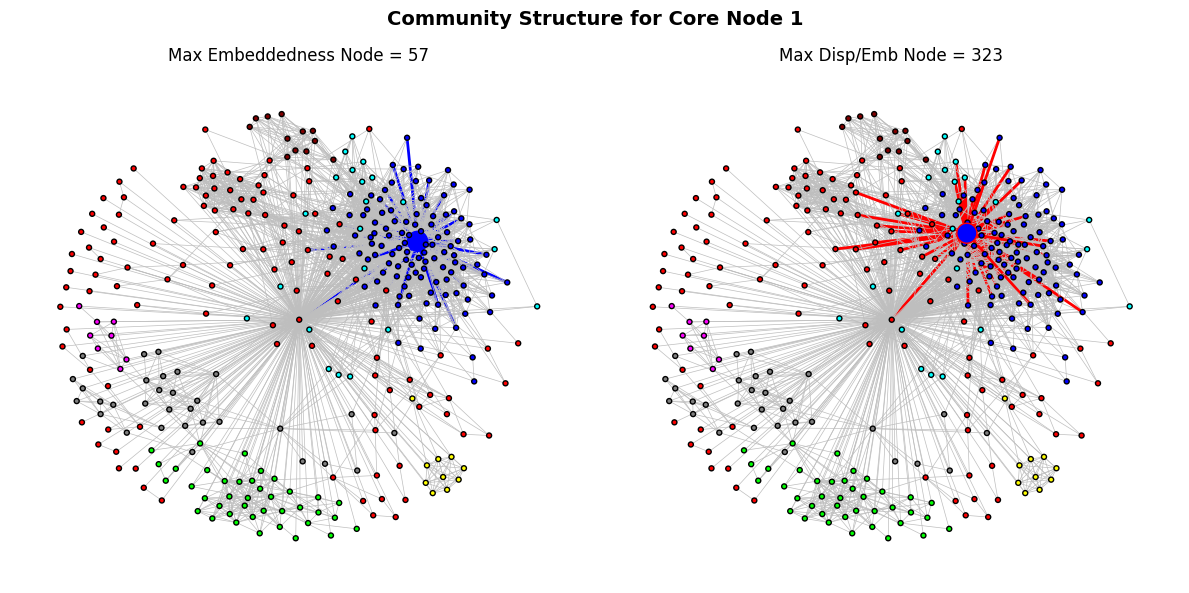

Core Node 1:
  Max Embeddedness Node (Graph ID) = 57
  Max Dispersion/Embeddedness Node (Graph ID) = 323


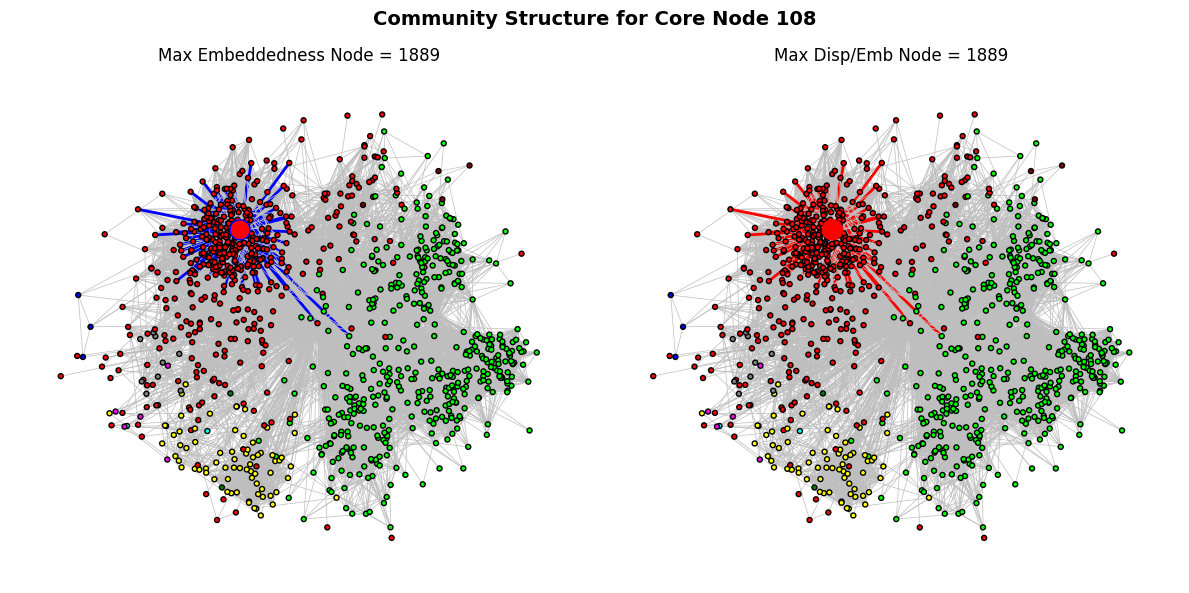

Core Node 108:
  Max Embeddedness Node (Graph ID) = 1889
  Max Dispersion/Embeddedness Node (Graph ID) = 1889


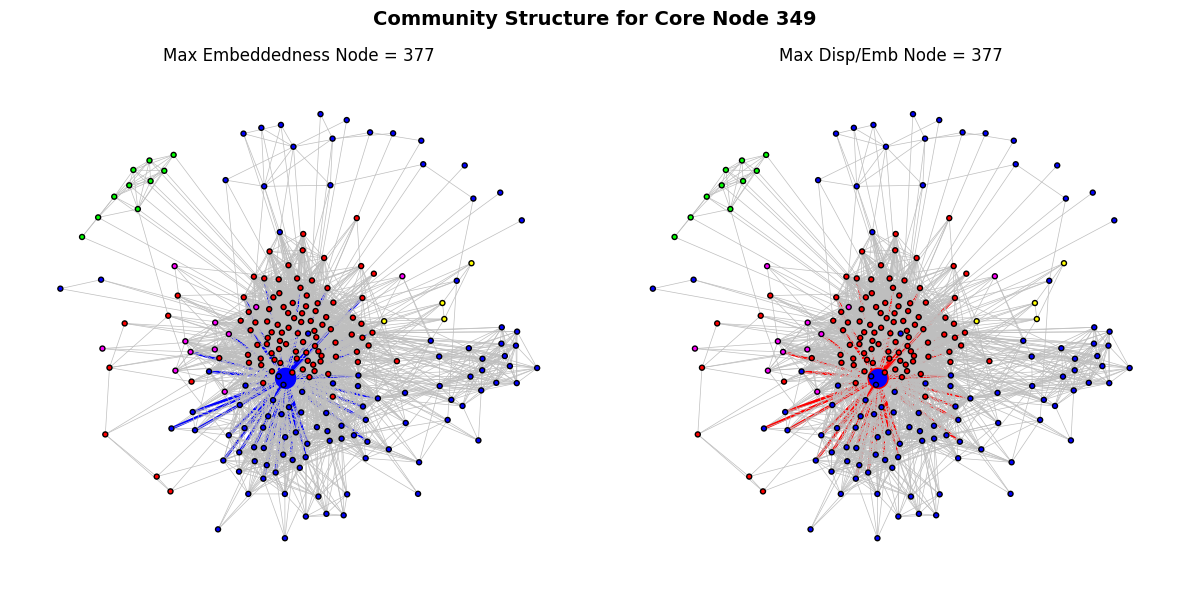

Core Node 349:
  Max Embeddedness Node (Graph ID) = 377
  Max Dispersion/Embeddedness Node (Graph ID) = 377


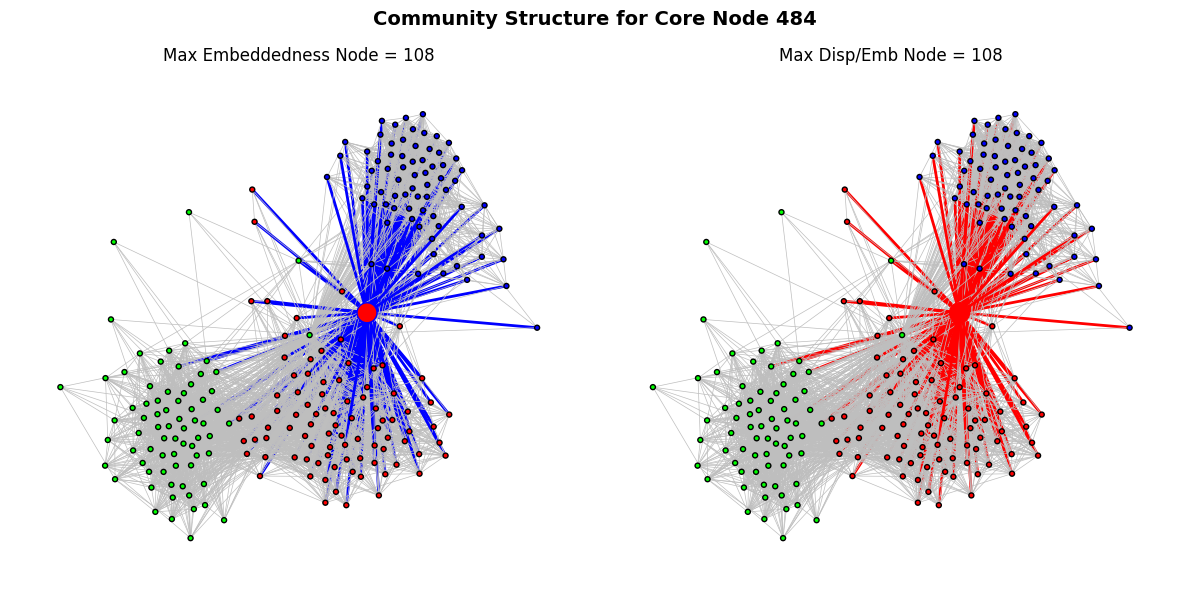

Core Node 484:
  Max Embeddedness Node (Graph ID) = 108
  Max Dispersion/Embeddedness Node (Graph ID) = 108


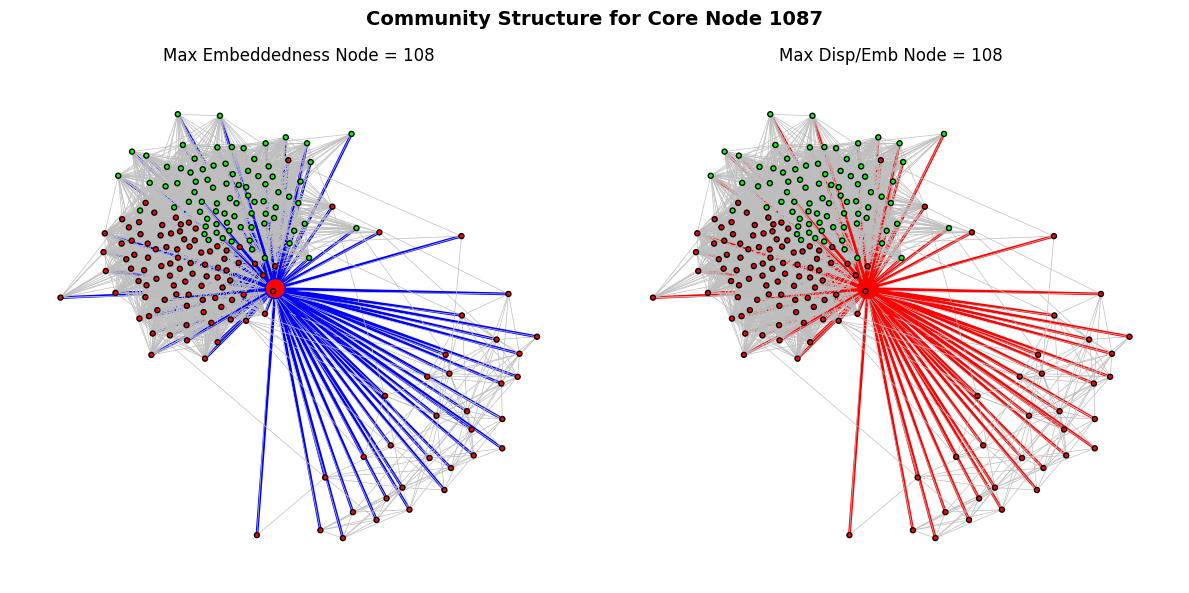

Core Node 1087:
  Max Embeddedness Node (Graph ID) = 108
  Max Dispersion/Embeddedness Node (Graph ID) = 108


In [24]:
core_nodes_graph_id = [1, 108, 349, 484, 1087]
core_nodes_edge_id = [id - 1 for id in core_nodes_graph_id]

for core_id in core_nodes_edge_id:
    plot_community_highlight_emb_disp_ratio(G_fb, core_id)

Ans:

In a personalized network, a node exhibits high embeddedness when it shares a large number of mutual friends with the core node. This indicates that the node has a strong connection and similarity to the core node. Since mutual friends are directly linked to the degree in the personalized network, the node with the highest embeddedness is also the one with the most neighbors. This is reflected in the visualizations, where such nodes tend to appear at the center of the network structure.

On the other hand, a node’s dispersion is low if its mutual friends are closely connected to each other. A low dispersion suggests that the mutual friends form a tightly knit group. However, if the mutual friends are sparsely connected or disconnected, dispersion values can be affected because infinite distances are ignored in the calculation. Generally, a node with high dispersion has a larger set of mutual friends that are more sparsely connected. This observation matches the plots, where the nodes with the highest dispersion often also have high embeddedness.

The $\dfrac{\text{dispersion}}{\text{embeddedness}}$ ratio further captures the relationship between dispersion and the number of mutual connections. A node with a high ratio ideally has high dispersion relative to its embeddedness, meaning its mutual friends are less densely clustered despite having fewer total connections. From the plots, we observe that for most personalized networks, the node with the highest ratio overlaps with the node with maximum embeddedness and dispersion. However, for the network centered at Node ID=1, this pattern does not hold, possibly because multiple nodes have comparable dispersion and embeddedness values, leading to a different node being selected when considering the ratio.

## 4. Friend recommendation in personalized networks
In many social networks, it is desirable to predict future links between pairs of nodes in the network. In the context of this Facebook network it is equivalent to recommending friends to users. In this part of the project, we will explore some neighborhood-based measures for friend recommendation. The network that we will be using for this part is the personalized network of node with ID 415.

In the following experiments, we focus on the personalized network of node ID 415 (which corresponds to index 414). 
- $S_i$ is the neighbor set of node i in the network
- $S_j$ is the neighbor set of node j in the network

We will apply three different neighborhood-based similarity measures:

- Common neighbor measure between nodes $i$ and $j$:
$$\text{Common Neighbors}(i, j) = |S_i \cap S_j|$$

- Jaccard similarity between nodes $i$ and $j$:
$$\text{Jaccard}(i, j) = \frac{|S_i \cap S_j|}{|S_i \cup S_j|}$$

- Adamic-Adar index between nodes $i$ and $j$:
$$\text{Adamic Adar}(i, j) = \sum_{k \in S_i \cap S_j} \frac{1}{\log |S_k|}$$

The recommendation procedure for a node $i$ operates as follows (illustrated using the Jaccard measure):

1.	For each node $j$ that is not currently a neighbor of $i$, compute the corresponding similarity measure:

$$\text{compute Jaccard}(i, j) \quad \forall j \in S_i^C$$

2.	Select the top $t$ nodes with the highest Jaccard measure (score) with node $i$ and recommend these nodes as new friends to node $i$.

#### QUESTION 16: What is $|N_r|$, i.e. the length of the list $N_r$?

Having defined the friend recommendation procedure, we can now apply it to the personalized network of node **ID 415**. Before we apply the algorithm, we need to create the list of users who we want to recommend new friends to. We create this list by picking all nodes with degree 24.

We will denote this list as $N_r$.

In [25]:
TARGET_DEGREE = 24

core_node_id = 415 - 1 # # node ID 415 -> edgelist index 414
personalized_network, core_node = get_personalized_network(G_fb, core_node_id)

nodes_with_target_degree = []

for v in personalized_network.vs:
    node_degree = personalized_network.degree(v)
    if node_degree == TARGET_DEGREE:
        nodes_with_target_degree.append(v.index)

print(f"|N_r| = {len(nodes_with_target_degree)}")
print(f"Answer: There are {len(nodes_with_target_degree)} users in the list.")

|N_r| = 11
Answer: There are 11 users in the list.


### 4.4. Average accuracy of friend recommendation algorithm

In this part, we will apply the 3 different types of friend recommendation algorithms to recommend friends to the users in the list $N_r$. We will define an average accuracy measure to compare the performances of the friend recommendation algorithms.

Suppose we want to compute the average accuracy of the friend recommendation algorithm. This task is completed in two steps:

1. Compute the average accuracy for each user in the list $N_r$.
2. Compute the average accuracy of the algorithm by averaging across the accuracies of the users in the list $N_r$.

Let’s describe the procedure for accomplishing the step 1 of the task. Suppose we want to compute the average accuracy for user $i$ in the list $N_r$. We can compute it by iterating over the following steps 10 times and then taking the average:

1. Remove each edge of node $i$ at random with probability 0.25. In this context, it is equivalent to deleting some friends of node $i$. Let’s denote the list of friends deleted as $R_i$.
2. Use one of the three neighborhood based measures to recommend $|R_i|$ new friends to the user $i$. Let’s denote the list of friends recommended as $P_i$.
3. The accuracy for the user $i$ for this iteration is given by $\frac{|P_i \cap R_i|}{|R_i|}$.

By iterating over the above steps for 10 times and then taking the average gives us the average accuracy of user $i$. In this manner, we compute the average accuracy for each user in the list $N_r$.

$N_r$. Once we have computed them, then we can take the mean of the average accuracies of the users in the list $N_r$. The mean value will be the average accuracy of the friend recommendation algorithm.


#### QUESTION 17:
Compute the average accuracy of the friend recommendation algorithm that uses:

- Common Neighbors measure
- Jaccard measure
- Adamic Adar measure

Based on the average accuracy values, which friend recommendation algorithm is the best?

**Hint** Useful function(s): `similarity`

In [26]:
from copy import deepcopy
import math
def common_neighbor_score(graph, node1, node2):
    neighbors1 = set(graph.neighborhood(node1))
    neighbors2 = set(graph.neighborhood(node2))
    return len(neighbors1.intersection(neighbors2))

def jaccard_score(graph, node1, node2):
    neighbors1 = set(graph.neighborhood(node1))
    neighbors2 = set(graph.neighborhood(node2))
    union_size = len(neighbors1.union(neighbors2))
    if union_size == 0:
        return 0
    return len(neighbors1.intersection(neighbors2)) / union_size

def adamic_adar_score(graph, node1, node2):
    neighbors1 = set(graph.neighborhood(node1))
    neighbors2 = set(graph.neighborhood(node2))
    common = neighbors1.intersection(neighbors2)
    score = 0
    for node in common:
        deg = graph.degree(node)
        if deg > 1:
            score += 1 / math.log(deg)
    return score

In [27]:

def recommend_accuracy(graph, target_id, mode="common"):
    temp_graph = deepcopy(graph)

    # randomly delete 25% of neighbor edges
    neighbor_edges = graph.incident(target_id)
    deleted_edges = [e for e in neighbor_edges if random.random() < 0.25]
    temp_graph.delete_edges(deleted_edges)

    # record the deleted neighbors
    original_neighbors = set(graph.neighborhood(target_id))
    current_neighbors = set(temp_graph.neighborhood(target_id))
    deleted_neighbors = original_neighbors - current_neighbors
    if not deleted_neighbors:
        return 0

    # For non-neighbors, compute scores
    scores = []
    for node in temp_graph.vs:
        if node.index not in current_neighbors and node.index != target_id:
            if mode == "common":
                score = common_neighbor_score(temp_graph, target_id, node.index)
            elif mode == "jaccard":
                score = jaccard_score(temp_graph, target_id, node.index)
            elif mode == "adamic":
                score = adamic_adar_score(temp_graph, target_id, node.index)
            else:
                raise ValueError("Unknown mode")
            scores.append((node.index, score))
    
    # Recommend top |deleted_neighbors| nodes
    scores.sort(key=lambda x: x[1], reverse=True)
    recommend_nodes = {node for node, _ in scores[:len(deleted_neighbors)]}

    # Calculate accuracy
    correct = len(recommend_nodes.intersection(deleted_neighbors))
    return correct / len(deleted_neighbors)



def avg_accuracy(graph, target_ids, mode="common"):
    results = []
    for target_id in target_ids:
        accuracies = []
        for _ in range(10):
            acc = recommend_accuracy(graph, target_id, mode)
            if acc > 0:
                accuracies.append(acc)
        if accuracies:
            results.append(sum(accuracies) / len(accuracies))
    if results:
        return sum(results) / len(results)
    return 0

In [35]:
common_acc = avg_accuracy(personalized_network, nodes_with_target_degree, mode="common")
jaccard_acc = avg_accuracy(personalized_network, nodes_with_target_degree, mode="jaccard")
adamic_acc = avg_accuracy(personalized_network, nodes_with_target_degree, mode="adamic")

random.seed(50)
print(f"Common Neighbor - Accuracy: {common_acc}")
print(f"Jaccard - Accuracy: {jaccard_acc}")
print(f"Adamic-Adar - Accuracy: {adamic_acc}")

Common Neighbor - Accuracy: 0.8304168306441035
Jaccard - Accuracy: 0.8052936373390918
Adamic-Adar - Accuracy: 0.8348232323232323


Based on the observations above, Adamic-Adar achieves the best performance among the three algorithms.

However, after conducting multiple experiments with different random seeds, it was observed that the performances of Common Neighbors and Adamic-Adar are quite close, and both significantly outperform Jaccard.